# Burst Center Frequency

Finds the center frequency of a burst by integrating over time and fitting a gaussian to the spectrum

In [1]:
from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts = pd.read_csv('bursts.csv')
bursts

,filename,edge,angle,peak,sigmax,sigmay,Slope,drift (mhz/ms),drift error (mhz/ms)
0,01_puppi_57747_C0531+33_0558_5.dm559.72.calibP...,1525,1.720000,10429.0,173.731526,47.364587,-6.652439,-1039.308995,0.617101
1,02_puppi_57747_C0531+33_0558_1183.dm559.72.cal...,1850,23.770000,5692.0,177.080918,44.911875,-4.736866,-739.419463,1.279131
2,03_puppi_57747_C0531+33_0558_1202.dm559.72.cal...,1975,-1.520000,5668.0,169.749001,19.463885,-19.669528,-2813.966383,5.239849
3,04_puppi_57747_C0531+33_0558_25437.dm559.72.ca...,1450,1.710000,5038.0,160.360329,26.706231,-7.137257,-1109.319273,40.321594
4,05_puppi_57747_C0531+33_0558_3683.dm559.72.cal...,1450,1.639204,5031.0,37.747383,166.280492,-14.595503,-2109.819670,124.715830
5,06_puppi_57747_C0531+33_0558_3687.dm559.72.cal...,1150,1.590000,5569.0,156.557708,12.416683,-52.066970,-6317.730503,30.736619
6,07_puppi_57747_C0531+33_0558_3688.dm559.72.cal...,1590,1.720000,5821.0,102.259272,38.969184,-6.652439,-1028.172298,2.175251
7,08_puppi_57747_C0531+33_0558_3689.dm559.72.cal...,2000,1.990000,5666.0,171.395398,64.792725,-2.244076,-340.010864,0.162096
8,09_puppi_57747_C0531+33_0558_3690.dm559.72.cal...,1600,2.240000,5041.0,133.024941,89.628038,-1.264288,-191.824534,9.704662
9,10_puppi_57747_C0531+33_0558_12568.dm559.72.ca...,800,-1.390000,5132.0,130.605616,47.074113,-5.470689,-846.471217,34.730967


In [9]:
bursts.head(16)

,filename,edge,angle,peak,sigmax,sigmay,Slope,drift (mhz/ms),drift error (mhz/ms)
0,01_puppi_57747_C0531+33_0558_5.dm559.72.calibP...,1525,1.720000,10429.0,173.731526,47.364587,-6.652439,-1039.308995,0.617101
1,02_puppi_57747_C0531+33_0558_1183.dm559.72.cal...,1850,23.770000,5692.0,177.080918,44.911875,-4.736866,-739.419463,1.279131
2,03_puppi_57747_C0531+33_0558_1202.dm559.72.cal...,1975,-1.520000,5668.0,169.749001,19.463885,-19.669528,-2813.966383,5.239849
3,04_puppi_57747_C0531+33_0558_25437.dm559.72.ca...,1450,1.710000,5038.0,160.360329,26.706231,-7.137257,-1109.319273,40.321594
4,05_puppi_57747_C0531+33_0558_3683.dm559.72.cal...,1450,1.639204,5031.0,37.747383,166.280492,-14.595503,-2109.819670,124.715830
5,06_puppi_57747_C0531+33_0558_3687.dm559.72.cal...,1150,1.590000,5569.0,156.557708,12.416683,-52.066970,-6317.730503,30.736619
6,07_puppi_57747_C0531+33_0558_3688.dm559.72.cal...,1590,1.720000,5821.0,102.259272,38.969184,-6.652439,-1028.172298,2.175251
7,08_puppi_57747_C0531+33_0558_3689.dm559.72.cal...,2000,1.990000,5666.0,171.395398,64.792725,-2.244076,-340.010864,0.162096
8,09_puppi_57747_C0531+33_0558_3690.dm559.72.cal...,1600,2.240000,5041.0,133.024941,89.628038,-1.264288,-191.824534,9.704662
9,10_puppi_57747_C0531+33_0558_12568.dm559.72.ca...,800,-1.390000,5132.0,130.605616,47.074113,-5.470689,-846.471217,34.730967


Burst #1
Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 94.04it/s]

Burst #2


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 92.89it/s]

Burst #3


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 95.99it/s]

Burst #4


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 95.58it/s]

Burst #5


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 94.51it/s]

Burst #6


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 93.69it/s]

Burst #7


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 95.17it/s]

Burst #8


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 96.03it/s]

Burst #9


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 93.48it/s]

Burst #10


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 95.91it/s]

Burst #11


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 92.35it/s]

Burst #12


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 94.68it/s]

Burst #13


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 94.93it/s]

Burst #14


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 93.88it/s]

Burst #15


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 93.79it/s]

Burst #16


Data loaded


noise removal: 100%|██████████| 411/411 [00:04<00:00, 93.81it/s]


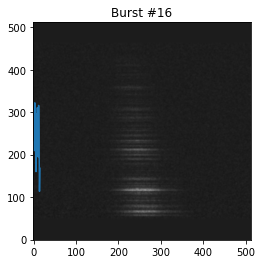

In [12]:
def findcenter(burst):
    burstnum = burst[0][:2].strip('0') if burst[0][:2][0] == '0' else burst[0][:2]
    print('Burst #{}'.format(burstnum))

    folder = 'data'
    filename = burst.filename
    edge = burst.edge

    junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    Q, U, V = None, None, None
    n = len(junk)
    print("Data loaded")

    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    tmin = 500 
    tmax = 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=False):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :

            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


        for j in range(tmax+1,binmax+1) :

            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

    burstwindow = intensity[:,edge:edge+frequencymax]
    plt.title('Burst #{}'.format(burstnum))
    freqspectrum = pd.DataFrame(burstwindow[:,:].sum(axis=1)[:, None])
    data = freqspectrum[50:463][0]
    x = data.keys()
    xo = sum(x*data)/sum(data)
    return xo # return the central frequency 

bursts['center'] = bursts.head(16).apply(findcenter, axis=1)


In [13]:
bursts['center']

0     228.755888
1     209.060564
2     249.051665
3     322.029396
4     214.396765
5     263.938012
6     160.167242
7     296.067560
8     216.215087
9     310.581676
10    263.108513
11    194.684720
12    315.871984
13    239.876953
14    113.702082
15    167.929660
16           NaN
17           NaN
Name: center, dtype: float64